In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import linear_regression
import matplotlib.pyplot as plt
import plorts

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from matplotlib.lines import Line2D

import energy_analysis_helpers

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yep260qv because the default path (/home/sarslan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
FIG_SIZE = (8,5)
plt.rcParams["figure.figsize"] = FIG_SIZE
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

In [3]:
N_CORES_TOT = 32

EXP_ID = '230524-1158'
data_folder = '../data/' + EXP_ID + '/'
exp_filename = data_folder + 'energy.log'

if (SAVE_FIG):
    out_dir = '../outputs/' + EXP_ID + '/'
    if (not os.path.exists(out_dir)):
        os.mkdir(out_dir)

# Reading the Experiment Data

In [4]:
exp_df = energy_analysis_helpers.read_energy_log(exp_filename)
exp_df['energy_kJ'] = exp_df['energy_uJ'] * 10e-9
exp_df = energy_analysis_helpers.read_iperf_log(exp_df, data_folder)
exp_df

,cc,mtu,bitrate,n_core,duration,cnt,energy_uJ,energy_kJ,total_cpu_util_percent,user_cpu_util_percent,system_cpu_util_percent,time_sec,sent_bytes,bps,rtx_pkts,min_rtt,mean_rtt,max_rtt,max_cwnd
0,stress,9000,0,0,10.0,1,2.348596e+08,2.348596,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stress,9000,0,0,10.0,2,2.128971e+08,2.128971,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stress,9000,0,0,10.0,3,2.219296e+08,2.219296,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,stress,9000,0,0,10.0,4,2.107860e+08,2.107860,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stress,9000,0,0,10.0,5,2.310167e+08,2.310167,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,cubic,9000,10,24,100.0,6,1.156185e+10,115.618467,96.863017,2.401998,94.461022,100.000117,1.228548e+11,9.828375e+09,2463.0,1.126,1.243,1.361,1539056.0
4318,cubic,9000,10,24,100.0,7,1.159283e+10,115.928282,99.107230,2.712203,96.395031,100.000134,1.193934e+11,9.551455e+09,1303.0,0.271,0.803,1.335,1718016.0
4319,cubic,9000,10,24,100.0,8,1.156537e+10,115.653748,97.048425,2.358970,94.689462,100.000072,1.231359e+11,9.850861e+09,2593.0,1.191,1.280,1.369,1753808.0
4320,cubic,9000,10,24,100.0,9,1.158624e+10,115.862426,97.100455,2.358178,94.742277,100.000108,1.229387e+11,9.835087e+09,2614.0,1.180,1.197,1.215,1592744.0


# Energy Consumption Analysis

In [5]:
energy_per_time_df = []
for cca, df in exp_df.groupby('cc'):
    if (cca in ['stress', 'sleep']):
        for n_core, ddf in df.groupby('n_core'):
            slope, _ = linear_regression(ddf['time_sec'], ddf['energy_kJ'], proportional=True)
            energy_per_time_df.append([cca, 0, n_core, slope])
    else:
        for bitrate, ddf in df.groupby('bitrate'):
            for n_core, dddf in ddf.groupby('n_core'):
                slope, _ = linear_regression(dddf['time_sec'], dddf['energy_kJ'], proportional=True)
                energy_per_time_df.append([cca, bitrate, n_core, slope])
energy_per_time_df = pd.DataFrame(energy_per_time_df, columns=['cc', 'bitrate', 'n_core', 'kJps'])
energy_per_time_df

,cc,bitrate,n_core,kJps
0,cubic,1,0,0.317200
1,cubic,1,8,0.903929
2,cubic,1,16,1.118162
3,cubic,1,24,1.145671
4,cubic,2,0,0.326537
5,cubic,2,8,0.902257
6,cubic,2,16,1.102773
7,cubic,2,24,1.147017
8,cubic,3,0,0.338873
9,cubic,3,8,0.906067


In [6]:
overhead_energy = \
    energy_per_time_df[energy_per_time_df.cc=='stress'][['n_core', 'kJps']].copy().set_index('n_core').to_dict()['kJps']
energy_per_time_df['kJps_noOverhead'] = \
    energy_per_time_df.apply(lambda row: row['kJps'] - overhead_energy[row['n_core']], axis=1)

In [7]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='kJps')
print('=== Power Consumption of Traffic and Background Cores (kJps) ===\n')
print(matrix)

=== Power Consumption of Traffic and Background Cores (kJps) ===

n_core         0         8         16        24
bitrate                                        
0        0.214920  0.896027  1.104587  1.143311
1        0.317200  0.903929  1.118162  1.145671
2        0.326537  0.902257  1.102773  1.147017
3        0.338873  0.906067  1.113002  1.148797
4        0.337676  0.908863  1.113453  1.150213
5        0.342335  0.909886  1.117843  1.152250
6        0.348210  0.912918  1.117149  1.154268
7        0.355466  0.916765  1.122748  1.156103
8        0.358559  0.917818  1.121159  1.157691
9        0.366897  0.921614  1.123461  1.158845
10       0.358231  0.926377  1.123559  1.157353


In [8]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='kJps_noOverhead')
print('=== Power Consumption of Traffic Only (kJps) ===\n')
print(matrix)

=== Power Consumption of Traffic Only (kJps) ===

n_core         0         8         16        24
bitrate                                        
0        0.000000  0.000000  0.000000  0.000000
1        0.102280  0.007902  0.013575  0.002360
2        0.111617  0.006230 -0.001814  0.003706
3        0.123953  0.010040  0.008416  0.005486
4        0.122756  0.012836  0.008866  0.006902
5        0.127416  0.013860  0.013257  0.008938
6        0.133290  0.016891  0.012563  0.010957
7        0.140547  0.020738  0.018161  0.012792
8        0.143639  0.021791  0.016573  0.014380
9        0.151977  0.025588  0.018874  0.015533
10       0.143312  0.030350  0.018973  0.014041


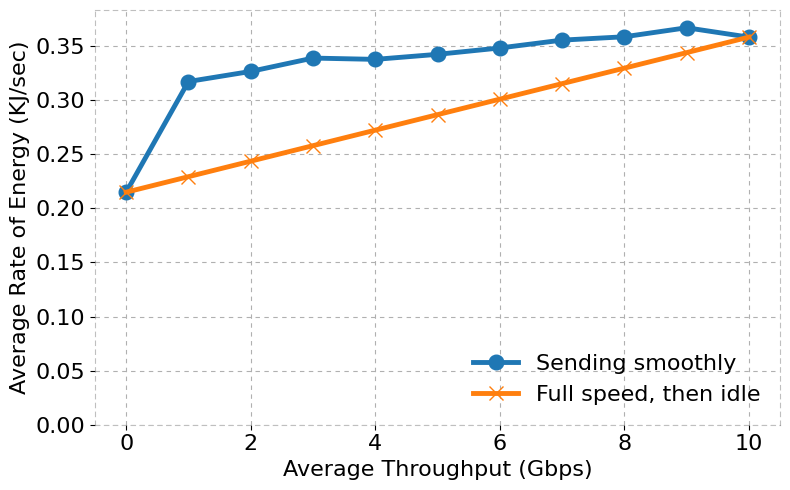

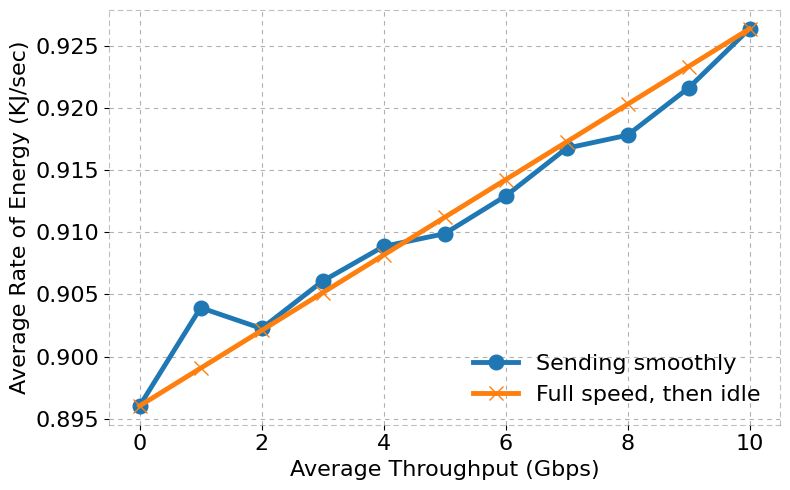

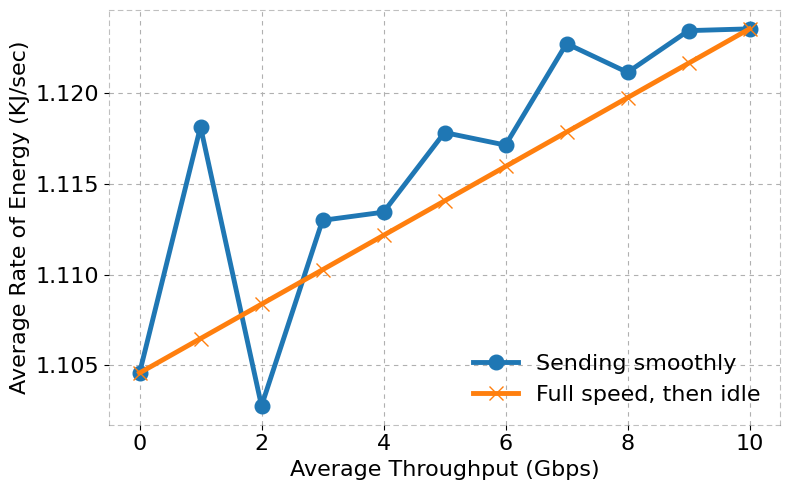

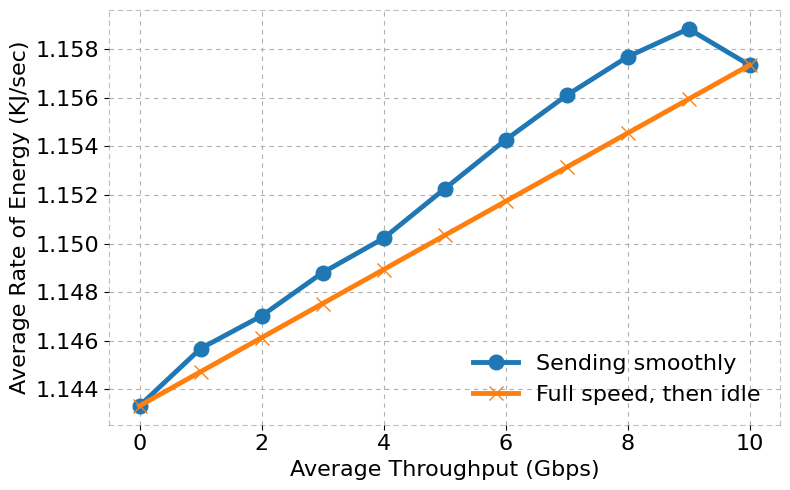

In [9]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_kJps = df[df.bitrate == 0].kJps.iloc[0]
    max_kJps = df[df.bitrate == 10].kJps.iloc[0]
    df['kJ_per_gb'] = df.kJps*1/df.bitrate + idle_kJps*(1 - 1/df.bitrate)
    df['kJ_full_speed'] = max_kJps*df.bitrate/10. + idle_kJps*(1 - df.bitrate/10.)

    plt.figure(figsize=FIG_SIZE)
    plt.plot(df.bitrate, df.kJps, marker='o', label='Sending smoothly', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.plot(df.bitrate, df.kJ_full_speed, marker='x', label='Full speed, then idle', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.ylabel("Average Rate of Energy (KJ/sec)", fontsize=FONT_SIZE)
    plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
    plt.legend(loc='best')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    if (n_core == 0):
        plt.ylim((0,df.kJ_full_speed.max()*1.07))
    plt.xticks(rotation = 0)
    plt.grid(linestyle=LINE_STYLE)
    leg = plt.gca().legend(loc='lower right', frameon=False, fontsize=FONT_SIZE)
    # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
    plt.gca().spines["right"].set_linestyle(LINE_STYLE)
    plt.gca().spines["right"].set_alpha(0.5)
    plt.gca().spines["right"].set_color('gray')
    plt.gca().spines["left"].set_linestyle(LINE_STYLE)
    plt.gca().spines["left"].set_alpha(0.5)
    plt.gca().spines["left"].set_color('gray')
    # plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["top"].set_linestyle(LINE_STYLE)
    plt.gca().spines["top"].set_alpha(0.5)
    plt.gca().spines["top"].set_color('gray')
    # plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["bottom"].set_color('gray')

    plt.tight_layout()
    # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

    if (SAVE_FIG):
        plt.savefig( out_dir + '/smooth_vs_bursty_{}_cores.pdf'.format(n_core))

    plt.show()

In [10]:
# for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
#     idle_kJps = df[df.bitrate == 0].kJps.iloc[0]
#     max_kJps = df[df.bitrate == 10].kJps.iloc[0]
#     df['kJ_per_gb'] = df.kJps*1/df.bitrate + idle_kJps*(1 - 1/df.bitrate)
#     df['kJ_full_speed'] = max_kJps*df.bitrate/10. + idle_kJps*(1 - df.bitrate/10.)

#     plt.figure(figsize=FIG_SIZE)
#     plt.plot(df.bitrate, df.kJps, marker='o',
#              linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
#     plt.ylabel("Average Rate of Energy (KJ/sec)", fontsize=FONT_SIZE)
#     plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
#     plt.xticks(fontsize=FONT_SIZE)
#     plt.yticks(fontsize=FONT_SIZE)
#     if (n_core == 0):
#         plt.ylim((0,df.kJ_full_speed.max()*1.07))
#     plt.xticks(rotation = 0)
#     plt.grid(linestyle=LINE_STYLE)
#     # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
#     plt.gca().spines["right"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["right"].set_alpha(0.5)
#     plt.gca().spines["right"].set_color('gray')
#     plt.gca().spines["left"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["left"].set_alpha(0.5)
#     plt.gca().spines["left"].set_color('gray')
#     # plt.gca().spines["top"].set_visible(False)
#     plt.gca().spines["top"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["top"].set_alpha(0.5)
#     plt.gca().spines["top"].set_color('gray')
#     # plt.gca().spines["bottom"].set_visible(False)
#     plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["bottom"].set_alpha(0.5)
#     plt.gca().spines["bottom"].set_color('gray')

#     plt.tight_layout()
#     # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

#     plt.show()

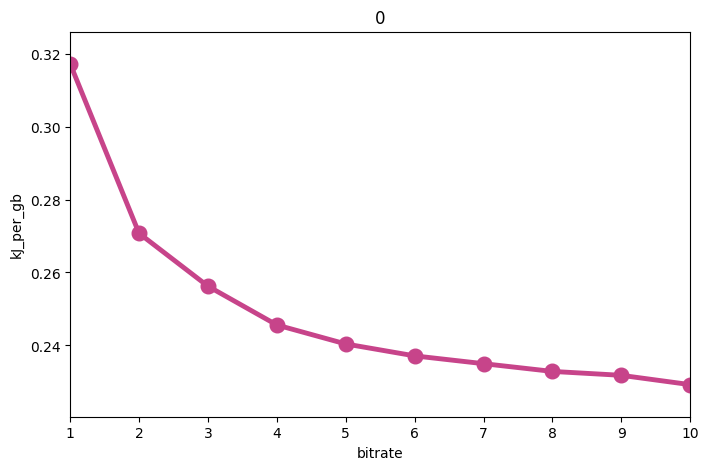

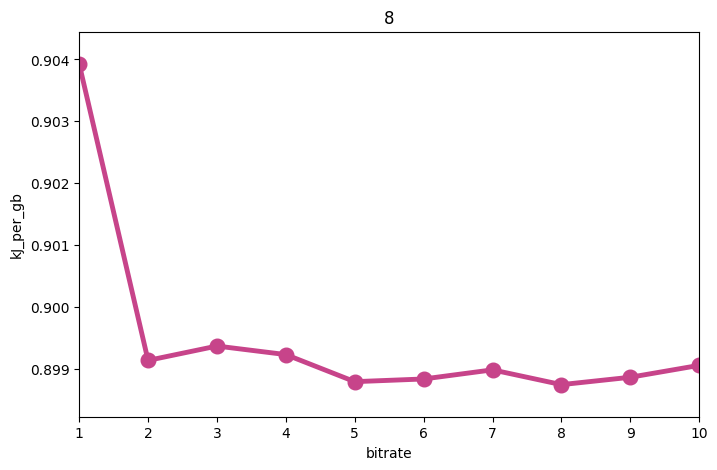

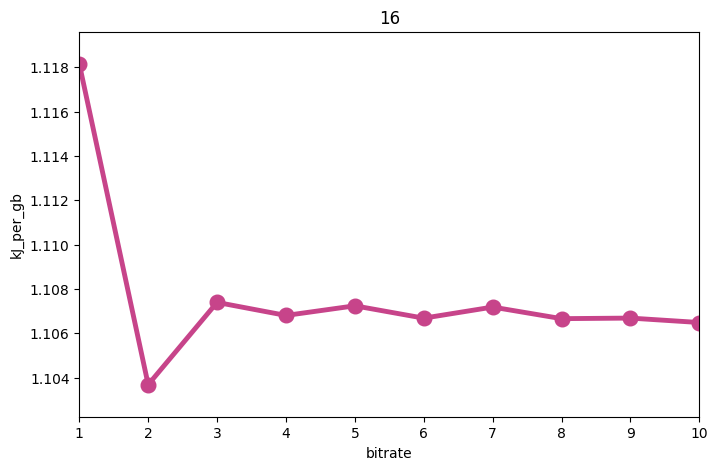

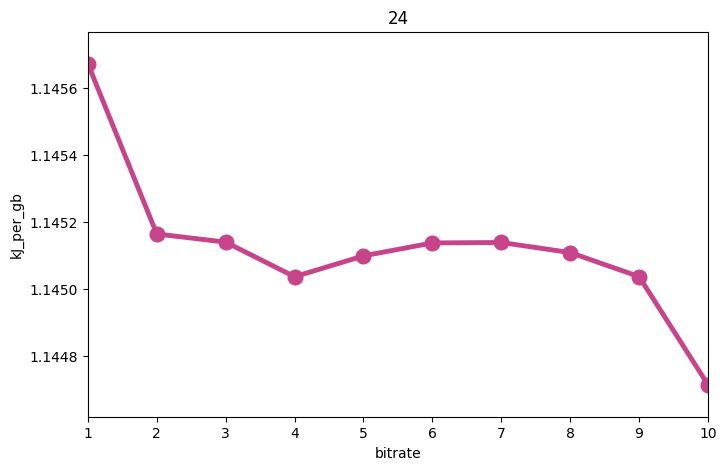

In [11]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_kJps = df[df.bitrate == 0].kJps.iloc[0]
    df['kJ_per_gb'] = df.kJps*1/df.bitrate + idle_kJps*(1 - 1/df.bitrate)
    plt.figure()
    plt.title(n_core)
    plorts.plot(df, x='bitrate', y='kJ_per_gb', marker='o', 
                linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

In [12]:
energy_per_bitrate = {}
for _,row in energy_per_time_df[energy_per_time_df.n_core == 0].iterrows():
    energy_per_bitrate[row.bitrate] = row.kJps
energy_per_bitrate

{1: 0.31719963701042725,
 2: 0.32653717436971325,
 3: 0.33887252239392995,
 4: 0.33767618091268564,
 5: 0.34233544104223756,
 6: 0.34820963430119556,
 7: 0.35546627268588493,
 8: 0.3585588564926029,
 9: 0.36689720895671385,
 10: 0.35823146469822514,
 0: 0.2149197500574026}

In [13]:
capacity = 10
file_size = capacity
duration = 2 * file_size / capacity
df = []
for fg_share_gbps in range(0,11):
    bg_share_gbps = capacity - fg_share_gbps
    if bg_share_gbps < fg_share_gbps:
        fct = file_size / fg_share_gbps
    else:
        fct = file_size / bg_share_gbps
        
    fg_left_to_send = file_size - fg_share_gbps * fct
    fg_full_time = fg_left_to_send / capacity
    fg_idle_time = duration - fct - fg_full_time
    fg_energy = energy_per_bitrate[fg_share_gbps]*fct + energy_per_bitrate[0]*fg_idle_time + energy_per_bitrate[10] * fg_full_time
    bg_left_to_send = file_size - bg_share_gbps*fct
    bg_full_time = bg_left_to_send / capacity
    bg_idle_time = duration - fct - bg_full_time
    bg_energy = energy_per_bitrate[bg_share_gbps]*fct + energy_per_bitrate[0]*bg_idle_time + energy_per_bitrate[10]*bg_full_time
    df.append({
        'capacity': capacity,
        'fct': fct,
        'fg_share_gbps':fg_share_gbps,
        'fg_idle_time':fg_idle_time,
        'fg_full_time': fg_full_time,
        'fg_energy':fg_energy,
        'bg_share_gbps':bg_share_gbps,
        'bg_left_to_send':bg_left_to_send,
        'bg_full_time':bg_full_time,
        'bg_idle_time':bg_idle_time,
        'bg_energy':bg_energy
    })
df = pd.DataFrame(df)
df['total_energy'] = df['fg_energy'] + df['bg_energy']
df

,capacity,fct,fg_share_gbps,fg_idle_time,fg_full_time,fg_energy,bg_share_gbps,bg_left_to_send,bg_full_time,bg_idle_time,bg_energy,total_energy
0,10,1.000000,0,0.000000e+00,1.000000,0.573151,10,0.000000,0.000000,1.000000e+00,0.573151,1.146302
1,10,1.111111,1,-1.110223e-16,0.888889,0.670872,9,0.000000,0.000000,8.888889e-01,0.598703,1.269575
2,10,1.250000,2,0.000000e+00,0.750000,0.676845,8,0.000000,0.000000,7.500000e-01,0.609388,1.286233
3,10,1.428571,3,0.000000e+00,0.571429,0.688807,7,0.000000,0.000000,5.714286e-01,0.630620,1.319428
4,10,1.666667,4,-5.551115e-17,0.333333,0.682204,6,0.000000,0.000000,3.333333e-01,0.651989,1.334193
5,10,2.000000,5,0.000000e+00,0.000000,0.684671,5,0.000000,0.000000,0.000000e+00,0.684671,1.369342
6,10,1.666667,6,3.333333e-01,0.000000,0.651989,4,3.333333,0.333333,-5.551115e-17,0.682204,1.334193
7,10,1.428571,7,5.714286e-01,0.000000,0.630620,3,5.714286,0.571429,0.000000e+00,0.688807,1.319428
8,10,1.250000,8,7.500000e-01,0.000000,0.609388,2,7.500000,0.750000,0.000000e+00,0.676845,1.286233
9,10,1.111111,9,8.888889e-01,0.000000,0.598703,1,8.888889,0.888889,-1.110223e-16,0.670872,1.269575


(0.0, 10.0, 0.0, 1.3916456976347198)

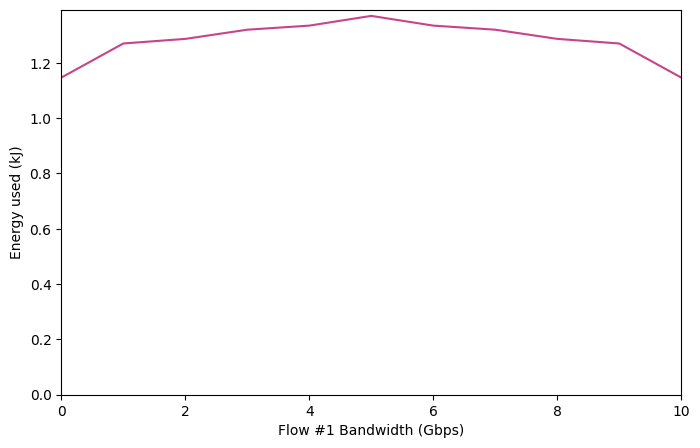

In [14]:
plorts.plot(df, x="fg_share_gbps", y='total_energy')
plt.xlabel("Flow #1 Bandwidth (Gbps)")
plt.ylabel("Energy used (kJ)")
plt.axis(ymin=0)

In [15]:
# fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
# df['energy_savings_pct'] = 100.0*(df['total_energy'] - fair_energy)/fair_energy
# df['fg_share_pct'] = 10*df['fg_share_gbps']

# plorts.plot(df, x="fg_share_pct", y='energy_savings_pct')
# plt.ylabel("% energy used over fair share")
# plt.xlabel("% bandwidth used by Flow #1")
# plt.axhline(y=0, linestyle=":", color='grey')
# plt.axvline(x=50, linestyle=":", color='grey')
# plt.text(52, -10, "Fair share", size=15)
# plorts.style_axis()

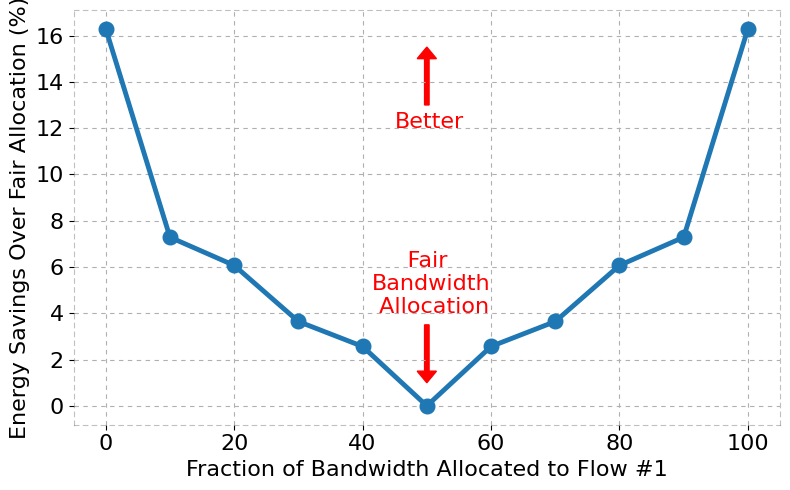

In [16]:
fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
df['energy_savings_pct'] = 100.0*(fair_energy - df['total_energy'])/fair_energy
df['fg_share_pct'] = 10*df['fg_share_gbps']

plt.figure(figsize=FIG_SIZE)
plt.plot(df.fg_share_pct, df.energy_savings_pct, marker='o', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

plt.ylabel("Energy Savings Over Fair Allocation (%)", fontsize=FONT_SIZE)
plt.xlabel("Fraction of Bandwidth Allocated to Flow #1", fontsize=FONT_SIZE)
plt.arrow(50, 3.5, 0, -2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(41.5, 4, "     Fair\nBandwidth\n Allocation", size=FONT_SIZE, color='red')
plt.arrow(50, 13, 0, 2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(45, 12, "Better", size=FONT_SIZE, color='red')

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
# plt.gca().spines["top"].set_visible(False)
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/fairness_vs_energy.pdf')

plt.show()

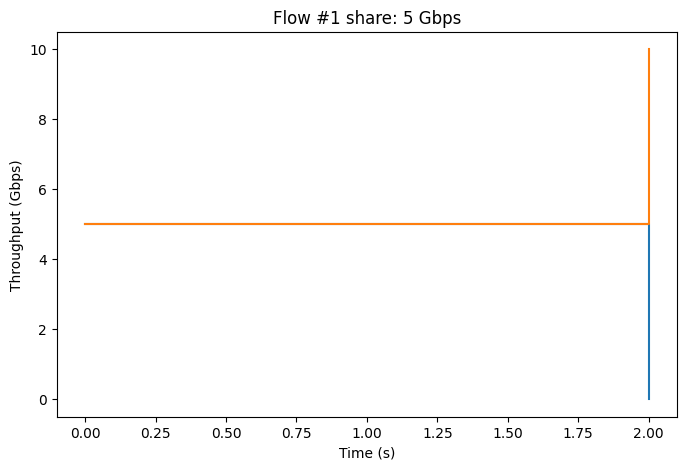

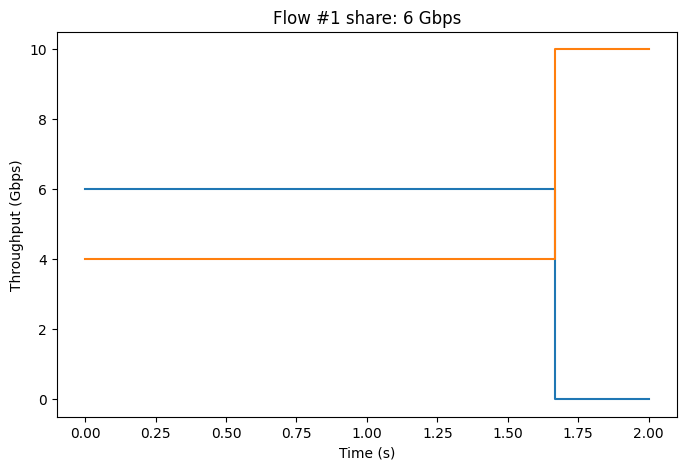

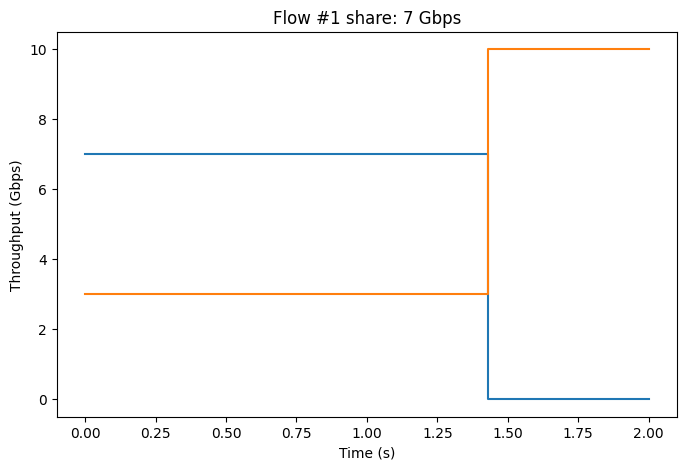

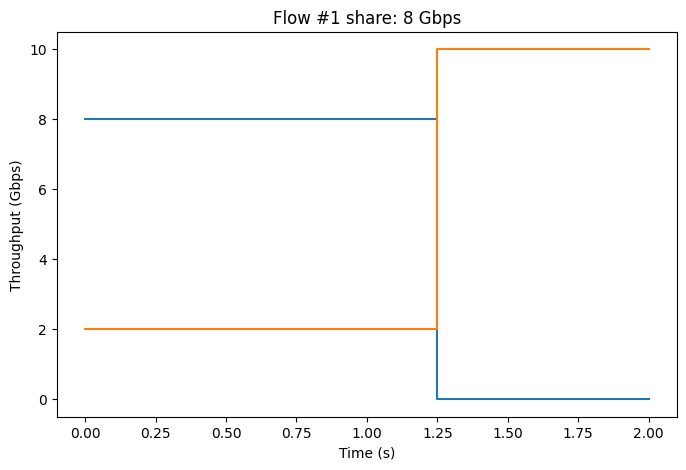

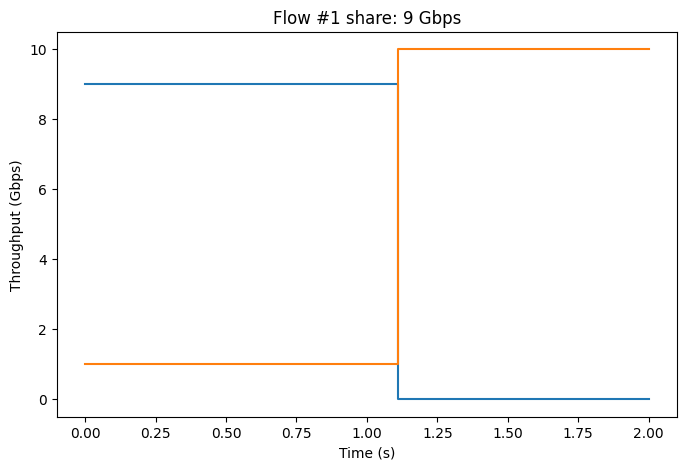

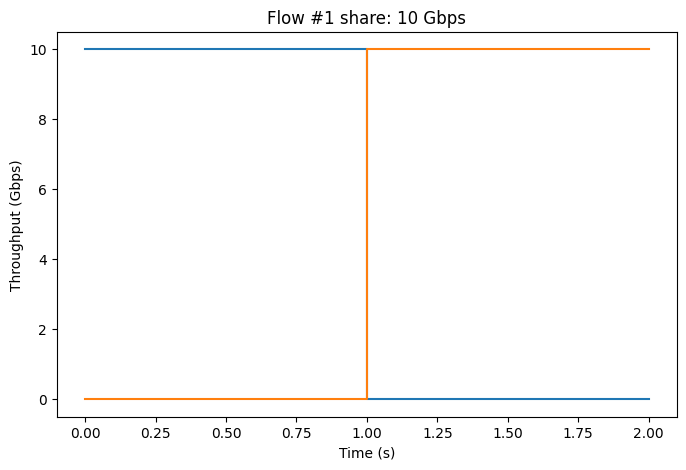

In [17]:
for _,exp in df.iterrows():
    if exp.fg_share_gbps < 5: continue
    plt.figure()
    plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.fg_share_gbps, exp.fg_share_gbps, 0, 0], label="Flow #1")
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.bg_share_gbps, exp.bg_share_gbps, exp.capacity, exp.capacity], label="Flow #2")
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Gbps)")
    if (SAVE_FIG):
        plt.savefig( out_dir + '/experiment_trace_{:.0f}_gbps.pdf'.format(exp.fg_share_gbps))

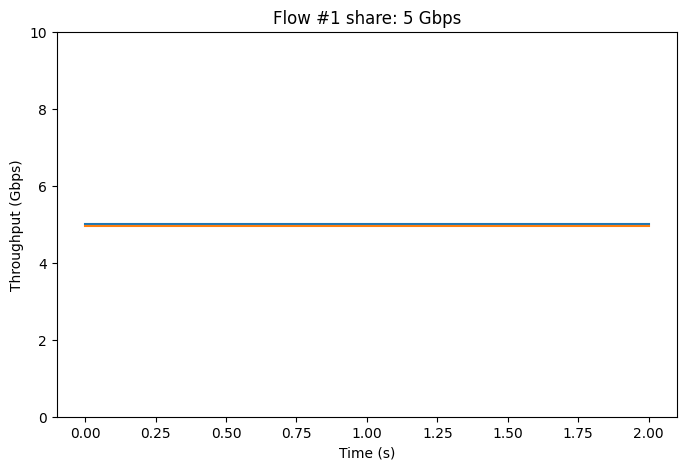

In [18]:
exp = df.iloc[5]
plt.figure()
plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
plt.plot([0, exp.fct], [exp.fg_share_gbps, exp.fg_share_gbps], label="Flow #1")
plt.plot([0, exp.fct], [exp.bg_share_gbps-0.05, exp.bg_share_gbps-0.05], label="Flow #2")
plt.axis(ymin=0,ymax=10)
plt.xlabel("Time (s)")
plt.ylabel("Throughput (Gbps)")
if (SAVE_FIG):
        plt.savefig( out_dir + f'/experiment_trace_{exp.fg_share_gbps.astype(int)}_gbps.pdf')